In [1]:
# import libraries
import pandas as pd
import numpy as np
import tweepy
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**1.Twitter archive**

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [5]:
twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [6]:
twitter_archive.sample(100)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2200,668655139528511488,NaN,NaN,2015-11-23 04:59:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Winifred. He is a Papyrus Hydrang...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668655139...,11,10,Winifred,None,None,None,None
1281,708810915978854401,NaN,NaN,2016-03-13 00:24:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mister. He's a wonderful father to his...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708810915...,10,10,Mister,None,None,None,None
1901,674646392044941312,NaN,NaN,2015-12-09 17:46:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Two gorgeous dogs here. Little waddling dog is...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674646392...,5,10,None,None,None,None,None
395,825535076884762624,NaN,NaN,2017-01-29 02:44:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very loving and accepting puppo. Appe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825535076...,14,10,None,None,None,None,puppo
644,793180763617361921,NaN,NaN,2016-10-31 20:00:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Newt. He's a strawberry. 11/10 https:/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793180763...,11,10,Newt,None,None,None,None
464,817415592588222464,NaN,NaN,2017-01-06 17:00:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Strudel. He's rather h*ckin pupset that y...,NaN,NaN,NaN,https://www.gofundme.com/help-strudel-walk-aga...,11,10,Strudel,None,None,None,None
2252,667801013445750784,NaN,NaN,2015-11-20 20:25:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMIGOD 12/10 https://t.co/SVMF4Frf1w,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667801013...,12,10,None,None,None,None,None
2347,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",My oh my. This is a rare blond Canadian terrie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090...,9,10,a,None,None,None,None
1939,673887867907739649,NaN,NaN,2015-12-07 15:32:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're having a great time sleeping and y...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673887867...,10,10,None,None,None,None,None
1683,681694085539872773,NaN,NaN,2015-12-29 04:31:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's a Benedoop Cumbersnatch. Seem...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681694085...,11,10,Bo,None,None,pupper,None


**2.Downloaded image predictions**

In [7]:
#Downloaded image_predictions.tsv programatically 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

#Load TSV file
image_predictions_df = pd.read_csv('image-predictions.tsv', sep='\t' )

In [8]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


**3. Get twitter API data**

In [10]:
# import tweepy
#from tweepy import OAuthHandler
#import json
#from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
#consumer_key = 'HIDDEN'
#consumer_secret = 'HIDDEN'
#access_token = 'HIDDEN'
#access_secret = 'HIDDEN'

#auth = OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
#tweet_ids = df_1.tweet_id.values
#len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
#count = 0
#fails_dict = {}
#start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    #for tweet_id in tweet_ids:
        #count += 1
        #print(str(count) + ": " + str(tweet_id))
        #try:
            #tweet = api.get_status(tweet_id, tweet_mode='extended')
            #print("Success")
            #json.dump(tweet._json, outfile)
            #outfile.write('\n')
        #except tweepy.TweepError as e:
            #print("Fail")
            #fails_dict[tweet_id] = e
            #pass
#end = timer()
#print(end - start)
#print(fails_dict)

In [11]:
url = 'https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'
response = requests.get(url)
with open('tweet-json.txt', mode ='wb') as file:
    file.write(response.content)

In [12]:
df_list = []
with open('tweet-json.txt', mode='r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        user_count = tweet['user']['followers_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count,
                       'user_count': user_count})
        
twitter_api = pd.DataFrame(df_list)
twitter_api.sample(10)

,favorite_count,retweet_count,tweet_id,user_count
2161,1425,792,669375718304980992,3201012
104,35324,8549,872122724285648897,3200891
844,7493,2166,766313316352462849,3200906
2214,265,79,668537837512433665,3201014
2010,953,347,672239279297454080,3201006
1555,1043,227,688804835492233216,3200951
1974,1001,328,672995267319328768,3201005
1679,3043,1161,681981167097122816,3200952
1762,5916,2880,678424312106393600,3200954
1409,3701,1113,698989035503689728,3200950


In [13]:
twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
user_count        2354 non-null int64
dtypes: int64(4)
memory usage: 73.6 KB


# Data Assess

**Check Duplicated **

In [14]:
sum(twitter_archive['tweet_id'].duplicated())

0

In [15]:
sum(image_predictions_df['tweet_id'].duplicated())

0

In [16]:
sum(twitter_api['tweet_id'].duplicated())

0

In [17]:
sum(image_predictions_df.jpg_url.duplicated())

66

**Others**

In [18]:
twitter_archive.name.sort_values()

1035            Abby
1021            Abby
938              Ace
1933            Acro
1327           Adele
1934           Aiden
77               Aja
480            Akumi
820               Al
875           Albert
1954          Albert
144            Albus
412            Albus
1115         Aldrick
2046       Alejandro
374        Alexander
1189    Alexanderson
486              Alf
2238           Alfie
661            Alfie
367            Alfie
1616           Alfie
858            Alfie
51              Alfy
201            Alice
1701           Alice
1495           Amber
1334         Ambrose
2078             Amy
2195          Amélie
            ...     
852               my
988              not
335              not
1747      officially
1206             old
993              one
1936             one
924              one
369              one
2326           quite
169            quite
118            quite
193            quite
2030           space
22              such
2345             the
2346         

In [19]:
twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Cooper        11
Oliver        11
Tucker        10
Penny         10
Lola          10
Bo             9
Winston        9
the            8
Sadie          8
an             7
Daisy          7
Bailey         7
Toby           7
Buddy          7
Scout          6
Jax            6
Koda           6
Oscar          6
Dave           6
Bella          6
Rusty          6
Milo           6
Stanley        6
Leo            6
Jack           6
Sammy          5
            ... 
Ridley         1
Timofy         1
Lolo           1
Alf            1
Iroh           1
Raphael        1
Dylan          1
Beemo          1
Lenox          1
Kara           1
Link           1
Brutus         1
Adele          1
Jaycob         1
Chadrick       1
Darla          1
Alexander      1
Tycho          1
Remus          1
Harrison       1
Devón          1
Damon          1
Coopson        1
Kobe           1
Reptar         1
Rizzo          1
Glacier        1
Tango         

### Quality Issues

#### Issues in image_predictions_df

1. Duplicated URLs (66). (#issue 1)
2. 'tweet_ID' should be string. (#issue 2)

#### Issues in twitter_api

1. 'tweet_ID' should be string. (#issue 3)

#### Issues in twitter_archive

1. Keep original ratings (no retweets). (#issue 4)
2. Not needed columns should be dropped. (#issue 5)
3. Timestamp is string & 'tweet_ID' should be string. (#issue 6)
4. rating_numerator and rating_denominator should convert to float. (#issue 7)
5. Name column has messy data.  (#issue 8)

### Tidiness

#### Issues in twitter_archive

1. Dog stages can be one column.  (#issue 9)
2. Separate date & time into two columns.  (#issue 10)

#### Issues in image_predictions_df

1. Columns name is not expressive. (#issue 11)

# Cleanning

In [20]:
twitter_archive_clean = twitter_archive.copy()

In [21]:
image_predictions_clean = image_predictions_df.copy()

In [22]:
twitter_api_clean = twitter_api.copy()

#### Issues in image_predictions_df

In [23]:
# issue 1
image_predictions_clean = image_predictions_clean.drop_duplicates(subset=['jpg_url'], keep='last')


In [24]:
sum(image_predictions_clean['jpg_url'].duplicated())

0

In [25]:
# issue 2
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype(str)

In [26]:
# issue 11
image_predictions_clean.rename(columns={'p1' : 'prediction_1',
                                  'p2' : 'prediction_2',
                                  'p3' : 'prediction_3',
                                  'p1_conf' : 'p1_confidence',
                                  'p2_conf' : 'p2_confidence',
                                  'p3_conf' : 'p3_confidence',
                                  'p1_dog' : 'predict_1_breed',
                                  'p2_dog' : 'predict_2_breed',
                                  'p3_dog' : 'predict_3_breed',
                                 }, inplace = True)

#### image_predictions_clean test


In [27]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,p1_confidence,predict_1_breed,prediction_2,p2_confidence,predict_2_breed,prediction_3,p3_confidence,predict_3_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [28]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id           2009 non-null object
jpg_url            2009 non-null object
img_num            2009 non-null int64
prediction_1       2009 non-null object
p1_confidence      2009 non-null float64
predict_1_breed    2009 non-null bool
prediction_2       2009 non-null object
p2_confidence      2009 non-null float64
predict_2_breed    2009 non-null bool
prediction_3       2009 non-null object
p3_confidence      2009 non-null float64
predict_3_breed    2009 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 162.8+ KB


#### Issues in twitter_api

In [29]:
# issue 3
twitter_api_clean.tweet_id = twitter_api_clean.tweet_id.astype(str)

#### twitter_api_clean test


In [30]:
twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null object
user_count        2354 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


#### Issues in twitter_archive

In [31]:
# issue 4
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean['retweeted_status_user_id'])]

In [32]:
# issue 5
twitter_archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id', 'expanded_urls'], axis=1, inplace=True)

In [33]:
# issue 6
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)

In [34]:
# issue 6
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype(str)

In [35]:
# issue 7
twitter_archive_clean.rating_numerator = twitter_archive_clean.rating_numerator.astype('float')
twitter_archive_clean.rating_denominator = twitter_archive_clean.rating_denominator.astype('float')

In [36]:
# issue 7
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]


,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,5.0,10.0,Bella,None,None,None,None
695,786709082849828864,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",75.0,10.0,Logan,None,None,None,None
763,778027034220126208,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,27.0,10.0,Sophie,None,None,pupper,None
1689,681340665377193984,2015-12-28 05:07:27,"<a href=""http://twitter.com/download/iphone"" r...",I've been told there's a slight possibility he...,5.0,10.0,None,None,None,None,None
1712,680494726643068929,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,26.0,10.0,None,None,None,None,None


In [37]:
# issue 8
twitter_archive_clean.name.replace(['such', 'an', 'the', 'just', 'by', 'a', 'mad', 'old', 'space', 
             'quite', 'actually', 'infuriating', 'all', 'officially', 'my', 'unacceptable', 'incredibly',
              'not', '0', 'life', 'one', 'his', 'very'],np.NaN, inplace =True)

In [38]:
twitter_archive_clean =  twitter_archive_clean.replace('None', np.nan)

In [39]:
twitter_archive.name.describe()

count     2356
unique     957
top       None
freq       745
Name: name, dtype: object

In [40]:
# issue 9
twitter_archive_clean.doggo.value_counts()

doggo    87
Name: doggo, dtype: int64

In [41]:
twitter_archive_clean.floofer.value_counts()

floofer    10
Name: floofer, dtype: int64

In [42]:
twitter_archive_clean.pupper.value_counts()

pupper    234
Name: pupper, dtype: int64

In [43]:
twitter_archive_clean.puppo.value_counts()

puppo    25
Name: puppo, dtype: int64

In [44]:
twitter_archive_clean['dog_stage'] = twitter_archive_clean['text'].str.extract('(doggo|floofer|pupper|puppo)')

In [48]:
twitter_archive_clean.sample(50)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
2183,668989615043424256,2015-11-24 03:08:48,"<a href=""http://twitter.com/download/iphone"" r...",This is Bernie. He's taking his Halloween cost...,3.0,10.0,Bernie,NaN,NaN,NaN,NaN,NaN
1499,692187005137076224,2016-01-27 03:26:56,"<a href=""http://twitter.com/download/iphone"" r...",This is a rare Arctic Wubberfloof. Unamused by...,12.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
1669,682429480204398592,2015-12-31 05:14:01,"<a href=""http://twitter.com/download/iphone"" r...","I know we joke around on here, but this is get...",8.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
1544,689517482558820352,2016-01-19 18:39:13,"<a href=""http://twitter.com/download/iphone"" r...",This is Carl. He just wants to make sure you'r...,12.0,10.0,Carl,NaN,NaN,NaN,NaN,NaN
1089,737800304142471168,2016-06-01 00:17:54,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She's ubering home after a few ...,10.0,10.0,Bella,NaN,NaN,NaN,NaN,NaN
2269,667509364010450944,2015-11-20 01:06:48,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This a Norwegian Pewterschmidt named Tickles. ...,12.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
1223,714251586676113411,2016-03-28 00:43:43,"<a href=""http://twitter.com/download/iphone"" r...",This is Thumas. He hates potted plants. 8/10 w...,8.0,10.0,Thumas,NaN,NaN,NaN,NaN,NaN
755,778748913645780993,2016-09-22 00:13:04,"<a href=""http://twitter.com/download/iphone"" r...","This is Mya (pronounced ""mmmyah?""). Her head i...",11.0,10.0,Mya,NaN,NaN,NaN,NaN,NaN
2163,669375718304980992,2015-11-25 04:43:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Billl. He's trying to be a ghost but h...,6.0,10.0,Billl,NaN,NaN,NaN,NaN,NaN
2162,669393256313184256,2015-11-25 05:52:43,"<a href=""http://twitter.com/download/iphone"" r...",Meet Ronduh. She's a Finnish Checkered Blitzkr...,10.0,10.0,Ronduh,NaN,NaN,NaN,NaN,NaN


In [49]:
twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [51]:
twitter_archive_clean.sample(10)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
1280,708834316713893888,2016-03-13 01:57:25,"<a href=""http://twitter.com/download/iphone"" r...",Meet Malikai. He was rolling around having fun...,10.0,10.0,Malikai,NaN
774,776218204058357768,2016-09-15 00:36:55,"<a href=""http://twitter.com/download/iphone"" r...",Atlas rolled around in some chalk and now he's...,13.0,10.0,NaN,floofer
931,754120377874386944,2016-07-16 01:08:03,"<a href=""http://twitter.com/download/iphone"" r...",When you hear your owner say they need to hatc...,10.0,10.0,NaN,NaN
1279,708845821941387268,2016-03-13 02:43:08,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper with magic eyes. Not wearing a...,9.0,10.0,NaN,pupper
2080,670823764196741120,2015-11-29 04:37:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Remington. He's a man dime. 12/10 http...,12.0,10.0,Remington,NaN
2045,671528761649688577,2015-12-01 03:18:27,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He's in the middle of a serious conv...,10.0,10.0,Jax,NaN
49,882762694511734784,2017-07-06 00:46:41,"<a href=""http://twitter.com/download/iphone"" r...",This is Gus. He's quite the cheeky pupper. Alr...,12.0,10.0,Gus,pupper
2234,668190681446379520,2015-11-21 22:14:07,"<a href=""http://twitter.com/download/iphone"" r...",This is Skittles. I would kidnap Skittles. Pin...,12.0,10.0,Skittles,NaN
1482,693267061318012928,2016-01-30 02:58:42,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Oscar. He can wave. Friendly af. 12/10...,12.0,10.0,Oscar,NaN
451,818627210458333184,2017-01-10 01:15:10,"<a href=""http://twitter.com/download/iphone"" r...",Meet Wafer. He represents every fiber of my be...,13.0,10.0,Wafer,NaN


In [52]:
# issue 10
#Split date & time
twitter_archive_clean['date'] = twitter_archive_clean['timestamp'].apply(lambda x: x.strftime('%d-%m-%Y'))
twitter_archive_clean['time'] = twitter_archive_clean['timestamp'].apply(lambda x: x.strftime('%H:%M:%S'))

#changing datatype of the date column to datetime
twitter_archive_clean.date = pd.to_datetime(twitter_archive_clean.date, dayfirst = True)

In [53]:
twitter_archive_clean.sample(30)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,date,time
167,859851578198683649,2017-05-03 19:26:06,"<a href=""http://twitter.com/download/iphone"" r...",Meet Trooper. He picks pup recyclables that ha...,13.0,10.0,Trooper,NaN,2017-05-03,19:26:06
1448,696405997980676096,2016-02-07 18:51:43,"<a href=""http://twitter.com/download/iphone"" r...",This is Berb. He just found out that they have...,7.0,10.0,Berb,NaN,2016-02-07,18:51:43
1807,676916996760600576,2015-12-16 00:09:23,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Super speedy pupper. Does not go gentle into t...,10.0,10.0,NaN,pupper,2015-12-16,00:09:23
986,749064354620928000,2016-07-02 02:17:13,"<a href=""http://twitter.com/download/iphone"" r...",Meet Winston. He's pupset because I forgot to ...,11.0,10.0,Winston,NaN,2016-07-02,02:17:13
2287,667177989038297088,2015-11-19 03:10:02,"<a href=""http://twitter.com/download/iphone"" r...",This is a Dasani Kingfisher from Maine. His na...,8.0,10.0,NaN,NaN,2015-11-19,03:10:02
361,829501995190984704,2017-02-09 01:27:41,"<a href=""http://twitter.com/download/iphone"" r...",This is Leo. He was a skater pup. She said see...,12.0,10.0,Leo,NaN,2017-02-09,01:27:41
1338,705066031337840642,2016-03-02 16:23:36,"<a href=""http://twitter.com/download/iphone"" r...",This is Reese. He's a Chilean Sohcahtoa. Loves...,12.0,10.0,Reese,NaN,2016-03-02,16:23:36
1256,710588934686908417,2016-03-17 22:09:38,"<a href=""http://twitter.com/download/iphone"" r...",This is Beemo. He's a Chubberflop mix. 12/10 w...,12.0,10.0,Beemo,NaN,2016-03-17,22:09:38
1409,699060279947165696,2016-02-15 02:38:53,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Yukon. He pukes rainbows. 12/10 magica...,12.0,10.0,Yukon,NaN,2016-02-15,02:38:53
809,771500966810099713,2016-09-02 00:12:18,"<a href=""http://twitter.com/download/iphone"" r...",This is Dakota. He's just saying hi. That's al...,12.0,10.0,Dakota,NaN,2016-09-02,00:12:18


In [54]:
twitter_archive_clean.drop(['timestamp'], axis=1, inplace=True)

In [55]:
twitter_archive_clean.head()

,tweet_id,source,text,rating_numerator,rating_denominator,name,dog_stage,date,time
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,NaN,2017-08-01,16:23:56
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,NaN,2017-08-01,00:17:27
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,NaN,2017-07-31,00:18:03
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,NaN,2017-07-30,15:58:51
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,NaN,2017-07-29,16:00:24


In [56]:
twitter_archive_clean = twitter_archive_clean.merge(image_predictions_clean, on = 'tweet_id', how = 'inner')

In [57]:
twitter_archive_clean = pd.merge(twitter_archive_clean, twitter_api_clean, on = 'tweet_id', how = 'left')

In [58]:
pd.set_option('display.max_columns', None)

In [59]:
twitter_archive_clean.head()

,tweet_id,source,text,rating_numerator,rating_denominator,name,dog_stage,date,time,jpg_url,img_num,prediction_1,p1_confidence,predict_1_breed,prediction_2,p2_confidence,predict_2_breed,prediction_3,p3_confidence,predict_3_breed,favorite_count,retweet_count,user_count
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,NaN,2017-08-01,16:23:56,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,39467,8853,3200889
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,NaN,2017-08-01,00:17:27,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,33819,6514,3200889
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,NaN,2017-07-31,00:18:03,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,25461,4328,3200889
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13.0,10.0,Darla,NaN,2017-07-30,15:58:51,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,42908,8964,3200889
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12.0,10.0,Franklin,NaN,2017-07-29,16:00:24,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,41048,9774,3200889


In [60]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 1927
Data columns (total 23 columns):
tweet_id              1928 non-null object
source                1928 non-null object
text                  1928 non-null object
rating_numerator      1928 non-null float64
rating_denominator    1928 non-null float64
name                  1307 non-null object
dog_stage             317 non-null object
date                  1928 non-null datetime64[ns]
time                  1928 non-null object
jpg_url               1928 non-null object
img_num               1928 non-null int64
prediction_1          1928 non-null object
p1_confidence         1928 non-null float64
predict_1_breed       1928 non-null bool
prediction_2          1928 non-null object
p2_confidence         1928 non-null float64
predict_2_breed       1928 non-null bool
prediction_3          1928 non-null object
p3_confidence         1928 non-null float64
predict_3_breed       1928 non-null bool
favorite_count        1928 n

In [61]:
twitter_archive_clean.to_csv('Twitter_archive_master.csv', index=False)


In [62]:
twitter_archive_master=pd.read_csv('Twitter_archive_master.csv')

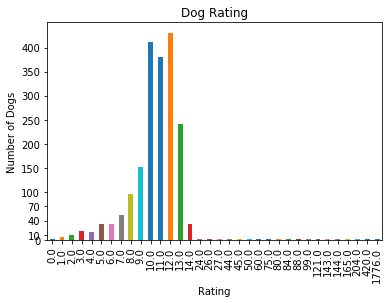

In [69]:
ax = twitter_archive_master.rating_numerator.value_counts().sort_index().plot('bar', title = 'Dog Rating')
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Dogs")
ax.set_yticks([0,10, 40,70,100,150, 200,250,300,350,400])
plt.savefig('rating')

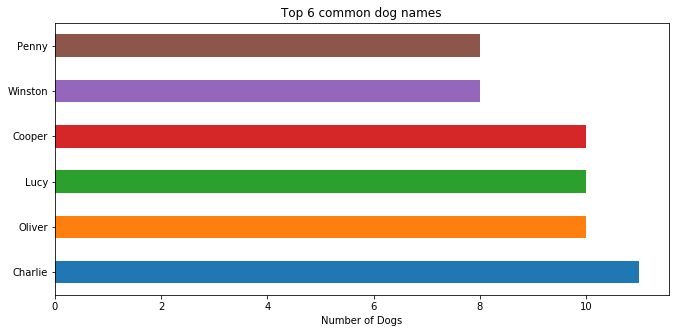

In [70]:
twitter_archive_master.name.value_counts()[0:6].plot('barh', figsize=(11,5), title='Top 6 common dog names').set_xlabel("Number of Dogs")
plt.savefig('Top 6 dog names')

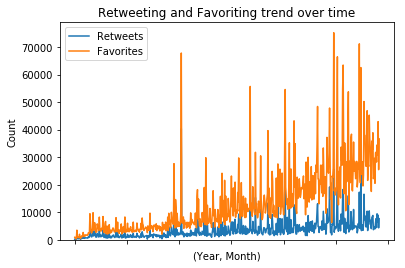

In [71]:
plt.subplots(1, sharex=True )
twitter_archive_master.retweet_count.groupby([twitter_archive_master["date"]]).mean().plot('line')
twitter_archive_master.favorite_count.groupby([twitter_archive_master["date"]]).mean().plot('line').set_ylim(0, )
plt.title('Retweeting and Favoriting trend over time')
plt.ylabel('Count')
plt.xlabel('(Year, Month)')
plt.legend(('Retweets', 'Favorites'))

In [72]:
twitter_archive_master.prediction_1.value_counts()

golden_retriever             128
Labrador_retriever            90
Pembroke                      87
Chihuahua                     75
pug                           52
Pomeranian                    38
chow                          38
Samoyed                       37
toy_poodle                    37
malamute                      28
French_bulldog                26
cocker_spaniel                24
Chesapeake_Bay_retriever      23
miniature_pinscher            21
seat_belt                     20
German_shepherd               20
Siberian_husky                20
teddy                         18
Eskimo_dog                    18
Maltese_dog                   18
Staffordshire_bullterrier     18
Shetland_sheepdog             18
Shih-Tzu                      17
Rottweiler                    17
kuvasz                        16
beagle                        16
Italian_greyhound             16
Lakeland_terrier              15
Cardigan                      15
web_site                      15
          

Text(0,0.5,'Count')

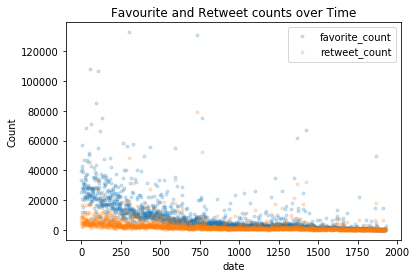

In [73]:
twitter_archive_master[['favorite_count', 'retweet_count']].plot(style = '.', alpha = 0.2)
plt.title('Favourite and Retweet counts over Time')
plt.xlabel('date')
plt.ylabel('Count')

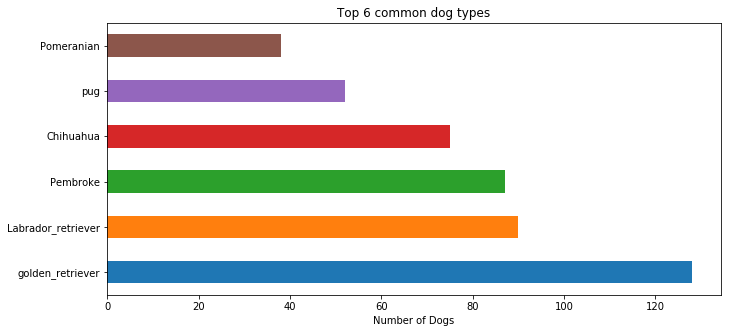

In [74]:
twitter_archive_master.prediction_1.value_counts()[0:6].plot('barh', figsize=(11,5), title='Top 6 common dog types').set_xlabel("Number of Dogs")
plt.savefig('Top 6 dog type')